# Distributed memory parallelism with mpi4py

## mpi4py basics

In MPI for Python, `Comm` is the base class of communicators. 

The two available predefined intracommunicator instances are `COMM_SELF` and `COMM_WORLD`. 

The number of processes in a communicator and the calling process rank can be respectively obtained with methods `Get_size()` and `Get_rank()`.

In [1]:
%%writefile communicator.py
from mpi4py import MPI

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

print('Number of processes is %i.' %size)
print('Hello, I am process %i.' % rank)

Writing communicator.py


To run an MPI-enabled Python application, one can use command **`mpirun -np .. python3 myprog.py`**, where users can specify how many processes MPI should start. 

The `mpirun` command below starts two-processes to run the `communicator.py` script. Each process gets the total number of processes and its own rank number.

In [2]:
!mpirun -np 4 --oversubscribe python3 communicator.py

Number of processes is 4.
Hello, I am process 3.
Number of processes is 4.
Hello, I am process 2.
Number of processes is 4.
Hello, I am process 0.
Number of processes is 4.
Hello, I am process 1.


When we run this program with ```mpirun```, the code is executed by all processors in the communicator. 
We need somehow to differentiate the work if we want to use efficiently MPI.

From the example above, try to make process ```rank == 0``` to print ```Hoi. Ik ben process 0``` instead.
You can use python syntax!!!

In [3]:
%%writefile communicator_mod.py
from mpi4py import MPI

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

# continue from here

Writing communicator_mod.py


In [4]:
!mpirun --oversubscribe -np 2 python3 communicator_mod.py

To look up the communication function definition, one can use `help(...)` as shown below.

In [5]:
from mpi4py import MPI
help(MPI.COMM_WORLD.Get_rank)

Help on built-in function Get_rank:

Get_rank(...) method of mpi4py.MPI.Intracomm instance
    Comm.Get_rank(self)
    
    Return the rank of this process in a communicator



In [6]:
from mpi4py import MPI
MPI.COMM_WORLD.Get_rank??

## Collective Communications

Collective communications allow the communication of data between multiple processes of a group simultaneously. 
Collective functions come in blocking versions only.

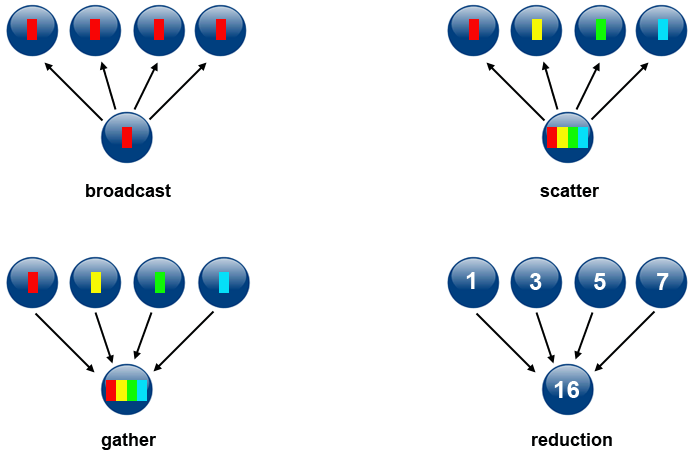

In [8]:
from IPython.display import Image
Image("/project/jhlsrf014/JHL_data/IMG/collective_comm.gif")

### Broadcast

In [1]:
%%writefile broadcast.py
from mpi4py import MPI
comm = MPI.COMM_WORLD
print("Hello")
if comm.rank == 0:
    data = [1,2,3,4]
else:
    data = None

data = comm.bcast(data)
print("rank:", comm.rank, "data:", data)

Overwriting broadcast.py


In [3]:
!mpirun -np 4 --oversubscribe python3 broadcast.py

Hello
Hello
Hello
Hello
rank: 0 data: [1, 2, 3, 4]
rank: 2 data: [1, 2, 3, 4]
rank: 3 data: [1, 2, 3, 4]
rank: 1 data: [1, 2, 3, 4]


### Scatter

In [4]:
%%writefile scatter.py
from mpi4py import MPI
comm = MPI.COMM_WORLD

if comm.rank == 0:
    data = [1,2,3,4]
else:
    data = None

data = comm.scatter(data)
print("rank:", comm.rank, "data:", data)

Writing scatter.py


In [5]:
!mpirun --oversubscribe -np 4 python3 scatter.py

rank: 0 data: 1
rank: 2 data: 3
rank: 3 data: 4
rank: 1 data: 2


### Gather

In [6]:
%%writefile gather.py
from mpi4py import MPI
comm = MPI.COMM_WORLD

data = comm.rank
gathered_data = comm.gather(data, root=0)

if comm.rank == 0:
    print("rank:", comm.rank, "data:", data)
    print("rank:", comm.rank, "data:", gathered_data)
else:
    print("rank:", comm.rank, "data:", data)
    print("rank:", comm.rank, "gathered data:", gathered_data)


Writing gather.py


In [ ]:
!mpirun --oversubscribe -np 4 python3 gather.py

rank: 1 data: 1
rank: 1 gathered data: None
rank: 2 data: 2
rank: 2 gathered data: None
rank: 3 data: 3
rank: 3 gathered data: None
rank: 0 data: 0
rank: 0 data: [0, 1, 2, 3]


### Reduction

To explain the reduction we are going to use the "PI with Montecarlo" example.

In [7]:
%%writefile reduction.py
from mpi4py import MPI
from random import random 
comm = MPI.COMM_WORLD

count = 0
t1 = MPI.Wtime()
for i in range(comm.rank,100000,comm.size):
    (x,y) = (random(), random())
    if x * x + y * y < 1.0:
        count += 1

sum_count = comm.reduce(count, MPI.SUM)
t2 = MPI.Wtime()

print(t2-t1)
if comm.rank == 0:
    print("pi = {}".format(4.0 * sum_count / 100000))


Writing reduction.py


In [8]:
!mpirun --oversubscribe -np 8 python3 reduction.py

0.063455139
0.052591365
0.018191574
0.062390883
0.048294533
pi = 3.14872
0.069723965
0.073330887
0.068996777


We are interested in performances. Let's time it with Python.

In [21]:
from mpi4py import MPI
help(MPI.Wtime)

Help on built-in function Wtime in module mpi4py.MPI:

Wtime(...)
    Wtime()
    
    Return an elapsed time on the calling processor



In [14]:
!hostname

r29n1.lisa.surfsara.nl


## Point-to-Point Communications.

Point to point communication enables the transmission of data between a pair of processes, one side sending, the other reciving. MPI provides a set of *send* and *receive* functions allowing the communication of *typed* data with an associated *tag*.

### Blocking Communications

Blocking functions in MPI block the caller until the data buffers involved in the communication can be safely reused by the application program.

In [9]:
%%writefile sendrecv.py
from mpi4py import MPI
comm = MPI.COMM_WORLD

if comm.rank == 0:
    comm.send("Hello world", 1)

if comm.rank == 1:
    message = comm.recv()
    print("Rank 1 received '%s'" %
          message)

Writing sendrecv.py


In [11]:
!mpirun -np 2 --oversubscribe python3 sendrecv.py

Rank 1 received 'Hello world'


Let's now take a look at the Alice/Bob example

In [17]:
%%writefile alicebob.py
from mpi4py import MPI
comm = MPI.COMM_WORLD

# Alice; say Hello to Bob
if comm.rank == 0:
    comm.ssend("Hello Bob!", 1)
    mesg = comm.recv()
    print("Alice: Bob said {}".format(mesg))

# Bob; say Hello to Alice
if comm.rank == 1:
    comm.send("Hello Alice!", 0)
    mesg = comm.recv()
    print("Bob: Alice said {}".format(mesg))


Overwriting alicebob.py


In [18]:
!mpirun -np 2 --oversubscribe python3 alicebob.py

Alice: Bob said Hello Alice!
Bob: Alice said Hello Bob!


MPI implementation usually eager-send small messages so ```MPI_Send()``` can return immediately, but this is an implementation choice not mandated by the standard, and "small" message depends on the library version, the interconnect you are using and other factors.

Trying changing the above ```comm.send``` with the secure ```comm.ssend``` and see what happens.

Can you solve the deadlock?

### Nonblocking Communications.

Nonblocking send and receive functions return immediately after *send/receive* operation. This means the process can continue to do something else, e.g. computation and check the status of the *send/receive* operation later.
This gives the possibility of overlapping communication and computation, such that the performance of the program can be increased.

In [1]:
%%writefile p2pisendirecv.py
from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

start = MPI.Wtime()

if rank == 0:
  data = {'a': 7, 'b': 3.14} 
  req = comm.isend(data, dest=1, tag=11)
  req.wait()
elif rank == 1:
  req = comm.irecv(source=0, tag=11)
  data = req.wait()

end = MPI.Wtime()
elapsed = end - start

print("Rank %d: Elapsed time is %f seconds.  Data is %r." % (rank, elapsed, data))

Overwriting p2pisendirecv.py


In [2]:
!mpirun -np 2 --oversubscribe python3 p2pisendirecv.py

Rank 0: Elapsed time is 0.000039 seconds.  Data is {'a': 7, 'b': 3.14}.
Rank 1: Elapsed time is 0.000100 seconds.  Data is {'a': 7, 'b': 3.14}.


**Exercise**:

Let each MPI process create a 10-elements numpy array, initialized with its own rank number.
Let process 0 calculate the total sum of all numpy arrays element-wise.
You can use the hints and template given below.

```
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
rank =                 # get process rank
size =                 # get total number of processes

sendbuf = np.zeros(10, dtype='i') + rank
recvbuf = None
if rank == 0:
  recvbuf = np.zeros(10, dtype='i')
comm.Reduce(, , op= , root=0)    # What should be reduced? And which operation is used?

if rank == 0:
  sum = sum(range(size))
  assert (recvbuf[:]==sum).all()
  print(recvbuf)
```

The result of the exercise should look like:

```
$mpirun -np 4 python3 reducenumpy.py 
[6 6 6 6 6 6 6 6 6 6]
```

```
$mpirun -np 5 python3 reducenumpy.py 
[10 10 10 10 10 10 10 10 10 10]
```

**Extra:** can you make Rank = 1 print the results?

### Working with numpy array 

MPI for Python can communicate any built-in or user-defined Python object by using the Python pickle module under the hood.

It also supports direct communication of any object exporting the single-segment buffer interface (e.g. Numpy arrays) with negligible overhead.

The Python buffer protocol is a framework in which Python objects can expose raw byte arrays to other Python objects.  Using the buffer protocol, we can let multiple objects efficiently manipulate views of the same data buffers, without having to make copies of the often large datasets.

As seen in the above examples, communication of generic Python objects makes use of **all-lowercase** methods of the `Comm` class, i.e. `send()`, `recv()`, `isend()`, etc.

To communicate buffer-like objects, one has to use method names starting with an **upper-case** letter, like `Send()`, `Recv()`, `Bcast()`, etc.

In general, buffer arguments to these calls must be explicitly specified by using a tuple like ```[data, MPI.DOUBLE]```, or ```[data, MPI.INT]```.

Let's see two examples using both methods:

In [3]:
%%writefile p2psendrecv.py
from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# initialize data
if rank == 0:
  data = [i for i in range(1000)]
# measure communication time
start = MPI.Wtime()
if rank == 0:
  comm.send(data, dest=1, tag=11)
elif rank == 1:
  data = comm.recv(source=0, tag=11)

end = MPI.Wtime()
elapsed = end - start

print("Rank %d: Elapsed time is %f seconds." % (rank, elapsed))

Writing p2psendrecv.py


In [5]:
!mpirun -np 2 --oversubscribe python3 p2psendrecv.py

Rank 0: Elapsed time is 0.004353 seconds.
Rank 1: Elapsed time is 0.000144 seconds.


In [6]:
%%writefile p2pnumpysendrecv.py
from mpi4py import MPI
import numpy

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# initialize data
if rank == 0:
  data = numpy.arange(1000, dtype='i')
elif rank == 1:
  data = numpy.empty(1000, dtype='i')

# measure communication time
start = MPI.Wtime()
if rank == 0:
  comm.Send([data, MPI.INT], dest=1, tag=77)
elif rank == 1:
  comm.Recv([data, MPI.INT], source=0, tag=77)
end = MPI.Wtime()
elapsed = end - start

print("Rank %d: Elapsed time is %f seconds." % (rank, elapsed))

Overwriting p2pnumpysendrecv.py


In [8]:
!mpirun -np 2 --oversubscribe python3 p2pnumpysendrecv.py

Rank 0: Elapsed time is 0.000060 seconds.
Rank 1: Elapsed time is 0.000041 seconds.


**Exercise:**

Modify `p2psendrecv.py` to communicate 1000 integers. How long does the communication take?

Compare the results with the ones obtained from `p2pnumpysendrecv.py` (the example above).

Which one is faster?

## Example: Matrix Vector multiplication.

Serial version of Matrix Vector multiplication.

In [9]:
%%writefile serial_matvec.py
"""
Serial version of Matrix-Vector Multiplication.
This code will run *iter* iterations of
  v(t+1) = M * v(t)
where v is a vector of length *size* and M a dense size*size
matrix. 
"""

import numpy as np
from numpy.fft import fft2, ifft2
from math import ceil, fabs
import time

size = 10000          # lengt of vector v
iter = 50             # number of iterations to run

# This is the complete vector
vec = np.zeros(size)            # Every element zero...
vec[0] = 1.0                    #  ... besides vec[0]

mat =np.zeros([size, size] , dtype='f')
mat[:,0] = 1.0
start = time.time()

for t in range(iter):
  result = np.inner(mat, vec)

stop = time.time()
elapsed = stop - start    ### Stop stopwatch ###

if fabs(result[iter]-1.0) > 0.01:
    print("!! Error: Wrong result!")

print(" %d iterations of size %d in %5.2fs: %5.2f iterations per second" %
    (iter, size, elapsed, iter/elapsed) 
)
print("============================================================================")

Writing serial_matvec.py


In [10]:
!python3 serial_matvec.py

 50 iterations of size 10000 in 11.32s:  4.42 iterations per second


Below is a parallel version of Matrix Vector multiplication implemented with mpi4py and numpy arrays. It is a modification of the original code provided at [4].

Try different number of processes and see whether you get any speed up. Can you explain the result you get?

In [37]:
%%writefile matvec.py
#!/usr/bin/env python 

"""
Demonstrating a MPI parallel Matrix-Vector Multiplication.
This code will run *iter* iterations of
  v(t+1) = M * v(t)
where v is a vector of length *size* and M a dense size*size
matrix. *size* must be an integer multiple of comm.size.
v is initialized to be zero except of v[0] = 1.0
M is a "off-by-one" diagonal matrix M[i, i+1] = 1.0
In effect, after *iter* iterations, the vector v should look like
v[iter] = 1. (all others zero).
In this example every MPI process is responsible for calculating a 
different portion of v. Every process only knows the stripe of M, that 
is relevant for it's calculation. At the end of every iteration, 
Allgather is used to distribute the partial vectors v to all other 
processes.
"""

from __future__ import division

import numpy as np
from numpy.fft import fft2, ifft2
from math import ceil, fabs
from mpi4py import MPI

size = 100000           # lengt of vector v
iter = 50               # number of iterations to run

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

if rank == 0:
  print("============================================================================")
  print(" Running %d parallel MPI processes" % comm.size)

my_size = size // comm.size     # Every process computes a vector of lenth *my_size*
size = comm.size*my_size        # Make sure size is a integer multiple of comm.size
my_offset = rank*my_size

# This is the complete vector
vec = np.zeros(size)            # Every element zero...
vec[0] = 1.0                    #  ... besides vec[0]

# Create my (local) slice of the matrix
my_M = np.zeros((my_size, size))
for i in range(my_size):
    j = (my_offset+i-1) % size
    my_M[i,j] = 1.0

comm.Barrier()
if rank == 0:                  
  start = MPI.Wtime()            ### Start stopwatch ###

for t in range(iter):
    my_new_vec = np.inner(my_M, vec)
    
    comm.Allgather(
        [my_new_vec, MPI.DOUBLE], 
        [vec, MPI.DOUBLE] 
    )
comm.Barrier()
if rank == 0:
  stop = MPI.Wtime()
  elapsed = stop - start    ### Stop stopwatch ###

  if fabs(vec[iter]-1.0) > 0.01:
      pprint("!! Error: Wrong result!")
  
  print(" %d iterations of size %d in %5.2fs: %5.2f iterations per second" %
      (iter, size, elapsed, iter/elapsed) 
  )
  print("============================================================================")

Overwriting matvec.py


In [38]:
!mpirun -np 2 python3 matvec.py

 Running 2 parallel MPI processes
^C


# References
#### [1] http://mpi4py.scipy.org/docs/usrman/index.html
#### [4] https://github.com/jbornschein/mpi4py-examples/blob/master/07-matrix-vector-product